# Jimi Togni - RA: 226359

-----------

## Parte 1 – Classificação binária


In [121]:
#importando pacotes essenciais

import numpy as np
import dateutil.parser as parse
import pandas as pd
import seaborn as sns
import matplotlib as mlp
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial.distance import correlation
import csv
import datetime
from datetime import *
%matplotlib inline

#plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [7]:
#funcoes

class Scaler:
    
    def __init__(self):
        self._mu = 0
        self._std = 0
    
    def fit(self, x):
        self._mu = np.mean(x)
        self._std = np.std(x)
    
    def transform(self, x):
        y = np.copy(x)
        return (y - self._mu) / self._std
    
    def inverse(self, x):
        y = np.copy(x)
        return (y * self._std) + self._mu
    
    def __repr__(self):
        return f"{self._mu}, {self._std}"
    

class Normalizer:
    
    def __init__(self):
        self._min = 0
        self._max = 0
    
    def fit(self, x):
        self._min = np.min(x)
        self._max = np.max(x)
    
    def transform(self, x):
        y = np.copy(x)
        return (y - self._min) / (self._max - self._min)

    def inverse(self, x):
        y = np.copy(x)
        return (y * (self._max - self._min)) + self._min 
        
    def __repr__(self):
        return f"{self._min}, {self._max}"




Problema: identificação do gênero do locutor a partir de trechos de voz
Base de dados: dados_voz_genero.csv
https://www.mldata.io/dataset-details/gender_voice/

Você dispõe de um conjunto de dados contendo 3168 amostras rotuladas. Cada
amostra é descrita por 19 atributos acústicos extraídos de trechos gravados de voz,
considerando a faixa de frequências de 0 a 280 Hz. A última coluna corresponde ao
rótulo associado a cada padrão, sendo igual a ‘1’ para o gênero masculino, e ‘0’ para o
gênero feminino.

a) Faça uma análise das características dos atributos de entrada considerando os
respectivos histogramas e as medidas de correlação entre eles.

b) Construa, então, o modelo de regressão logística para realizar a classificação
dos padrões. Para isso, reserve uma parte dos dados (e.g., 20%) para teste,
usando todas as demais amostras para o treinamento do modelo. Pensem na
pertinência e na possibilidade de realizar algum pré-processamento nos dados
(e.g., normalização).
Apresente e discuta os seguintes resultados com relação ao conjunto de teste:

 A curva ROC;

 A curva de evolução da -medida em função do valor do threshold de
decisão.

c) Indique qual seria o valor mais adequado para o threshold de decisão e por
quê. Empregando, então, esse threshold, obtenha a matriz de confusão e a
acurácia do classificador para o conjunto de teste. Comente os resultados
obtidos.


In [127]:
#Visualizando os dados

df = pd.read_csv('dados_voz_genero.csv')
print(f"Shape of data{df.shape}")
print(f"First 10 rows{df.head(5)}")


#convertendo para numpy
#df = np.array(data)
#print(f"Shape of np_data{df.shape}")

#np_data[:10, [1,3]]
#primeiras 10 linhas e a primeira e ultima colunas 
#data_np[:10, [0,-1]]
#data.head(10)

#colunas
#data_np.dtypes

Shape of data(3168, 21)
First 10 rows   Unnamed: 0        sd    median       Q25       Q75       IQR       skew  \
0           0  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1           1  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2           2  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3           3  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4           4  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   

          kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  ...  0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  ...  0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  ...  0.077316  0.098706  0.015656   
3     4.177296  0.963322  0.727232  ...  0.151228  0.088965  0.017798   
4     4.333713  0.971955  0.783568  ...  0.135120  0.106398  0.016931   

     maxfun   meandom    mindom    maxdom   dfrange   m

### heatmap ta bugado

In [ ]:
#matrix of correlation

def heatmap (x, y, size):
    fig, ax = plt.subplots()
    
    #mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    
    ax.scatter(
        x = x.map(x_to_num), #map for x
        y = y.map(y_to_num), #map for x
        s = size * size_scale,
        marker = 's'
    )
    
    # show column axes labels
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=90, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    

columns = ['skew', 'kurt', 'sp.ent', 'median', 'dfrange', 'modindx', 'maxdom']
corr = data[columns].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']

heatmap(x=corr['x'], y=['y'], size=corr['value'].abs())

#ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

**Selecionando os dados que possuem maior relação com audio de acordo com a matriz de correlaçao**

[Text(0.5, 0, 'Unnamed: 0'),
 Text(1.5, 0, 'sd'),
 Text(2.5, 0, 'median'),
 Text(3.5, 0, 'Q25'),
 Text(4.5, 0, 'Q75'),
 Text(5.5, 0, 'IQR'),
 Text(6.5, 0, 'skew'),
 Text(7.5, 0, 'kurt'),
 Text(8.5, 0, 'sp.ent'),
 Text(9.5, 0, 'sfm'),
 Text(10.5, 0, 'mode'),
 Text(11.5, 0, 'centroid'),
 Text(12.5, 0, 'meanfun'),
 Text(13.5, 0, 'minfun'),
 Text(14.5, 0, 'maxfun'),
 Text(15.5, 0, 'meandom'),
 Text(16.5, 0, 'mindom'),
 Text(17.5, 0, 'maxdom'),
 Text(18.5, 0, 'dfrange'),
 Text(19.5, 0, 'modindx'),
 Text(20.5, 0, 'label')]

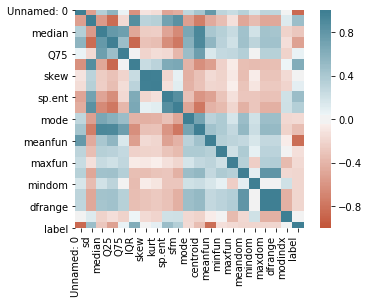

In [147]:
# mapa de correl total
#columns = ['skew', 'kurt', 'sp.ent', 'median', 'dfrange', 'modindx', 'maxdom']
corr = data.corr()

ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=90, horizontalalignment='right')

[Text(0.5, 0, 'skew'),
 Text(1.5, 0, 'kurt'),
 Text(2.5, 0, 'sp.ent'),
 Text(3.5, 0, 'median'),
 Text(4.5, 0, 'dfrange'),
 Text(5.5, 0, 'modindx'),
 Text(6.5, 0, 'maxdom')]

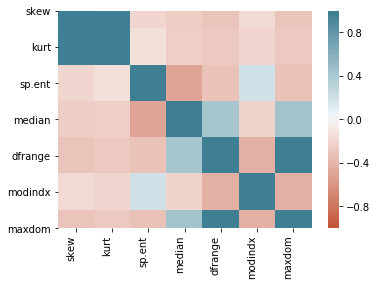

In [148]:
columns = ['skew', 'kurt', 'sp.ent',
           'median', 'dfrange', 'modindx', 'maxdom']
corr = data[columns].corr()

ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=90, horizontalalignment='right')

[Text(0.5, 0, 'skew'),
 Text(1.5, 0, 'kurt'),
 Text(2.5, 0, 'centroid'),
 Text(3.5, 0, 'mode'),
 Text(4.5, 0, 'sfm'),
 Text(5.5, 0, 'meanfun'),
 Text(6.5, 0, 'Q75'),
 Text(7.5, 0, 'Q25')]

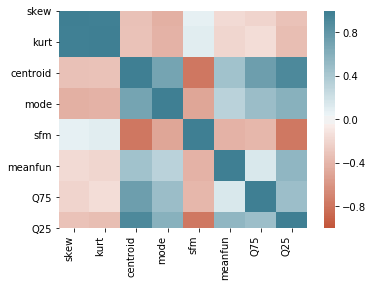

In [149]:
columns = ['skew', 'kurt', 'centroid',
           'mode', 'sfm', 'meanfun', 'Q75', 'Q25']
corr = data[columns].corr()

ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=90, horizontalalignment='right')

[Text(0.5, 0, 'skew'),
 Text(1.5, 0, 'kurt'),
 Text(2.5, 0, 'sp.ent'),
 Text(3.5, 0, 'mode'),
 Text(4.5, 0, 'sfm'),
 Text(5.5, 0, 'centroid'),
 Text(6.5, 0, 'label')]

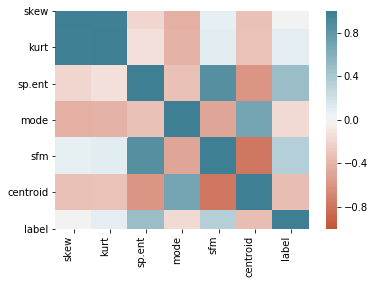

In [150]:
columns = ['skew', 'kurt', 'sp.ent',
           'mode', 'sfm', 'centroid', 'label']
corr = data[columns].corr()

ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200),
                 square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
                  rotation=90, horizontalalignment='right')

In [151]:
columns = df[['skew', 'kurt', 'sp.ent',
           'mode', 'sfm', 'centroid', 'label']]

**Histograma com os melhores parametros relacionados de acordo com a matriz de correlação**

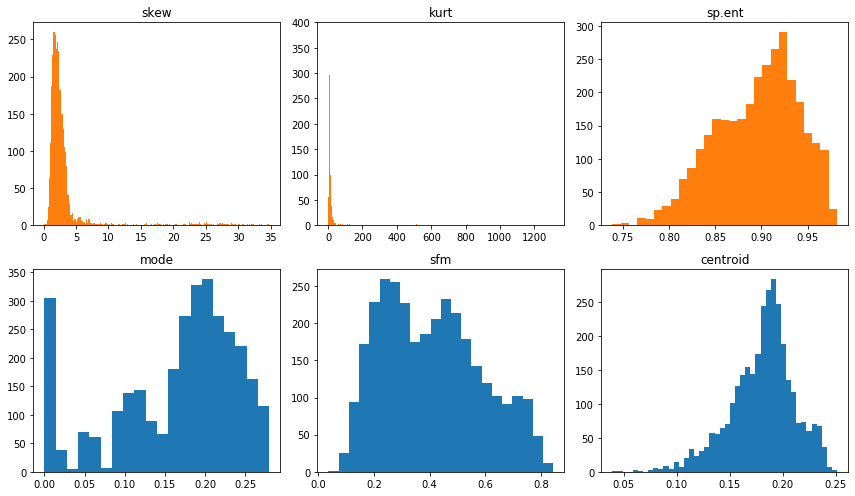

In [153]:
plt.figure(figsize=(12,7))

plt.subplot(2, 3, 1)
plt.title("skew")
plt.hist(columns["skew"], bins='auto', color='C1')

plt.subplot(2, 3, 2)
plt.title("kurt")
plt.hist(columns["kurt"], bins='auto', color='C1')

plt.subplot(2, 3, 3)
plt.title("sp.ent")
plt.hist(columns["sp.ent"], bins='auto', color='C1')

plt.subplot(2, 3, 4)
plt.title("mode")
plt.hist(columns["mode"], bins='auto')

plt.subplot(2, 3, 5)
plt.title("sfm")
plt.hist(columns["sfm"], bins='auto')

plt.subplot(2, 3, 6)
plt.title("centroid")
plt.hist(columns["centroid"], bins='auto')

plt.tight_layout()
plt.show()

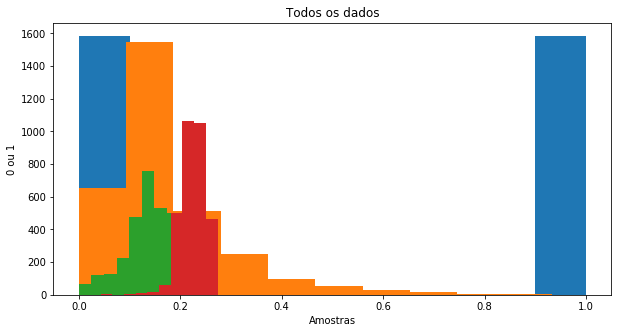

In [100]:
plt.figure(figsize=(10,5))
plt.hist(data_np[:, -1])
plt.hist(data_np[:, -2])
plt.hist(data_np[:, 3])
plt.hist(data_np[:, 4])
#plt.hist(data_np[:, 0], data_np[:, -1])
plt.title("Todos os dados")
plt.xlabel("Amostras")
plt.ylabel("0 ou 1")
plt.show()

In [33]:
data.head(10)

,Unnamed: 0,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1.0
1,1,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1.0
2,2,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1.0
3,3,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1.0
4,4,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1.0
5,5,0.079557,0.119090,0.067958,0.209592,0.141634,1.932562,8.308895,0.963181,0.738307,...,0.132786,0.110132,0.017112,0.253968,0.298222,0.007812,2.726562,2.718750,0.125160,1.0
6,6,0.074463,0.160106,0.092899,0.205718,0.112819,1.530643,5.987498,0.967573,0.762638,...,0.150762,0.105945,0.026230,0.266667,0.479620,0.007812,5.312500,5.304688,0.123992,1.0
7,7,0.076767,0.144337,0.110532,0.231962,0.121430,1.397156,4.766611,0.959255,0.719858,...,0.160514,0.093052,0.017758,0.144144,0.301339,0.007812,0.539062,0.531250,0.283937,1.0
8,8,0.078018,0.138587,0.088206,0.208587,0.120381,1.099746,4.070284,0.970723,0.770992,...,0.142239,0.096729,0.017957,0.250000,0.336476,0.007812,2.164062,2.156250,0.148272,1.0
9,9,0.080350,0.121451,0.075580,0.201957,0.126377,1.190368,4.787310,0.975246,0.804505,...,0.134329,0.105881,0.019300,0.262295,0.340365,0.015625,4.695312,4.679688,0.089920,1.0
